# Torque

In [1]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

### Teapots and Turntables

In [2]:
radius_disk = 0.5     # m
mass_disk = 7         # kg
radius_pot = 0.4      # m
mass_pot = 0.3        # kg
force = 2             # N

theta_push = 0.5        # radian, angle where I stop pushing on the turntable
theta_test = 1.5        # radian, how far the table turns during my test push
theta_target = numpy.pi       # radian, where we want the table to be after the second push

In [3]:
I_disk = mass_disk * radius_disk**2 / 2 # moment of inertia of the turntable

In [4]:
I_pot = mass_pot * radius_pot**2 # moment of intertia of the teapot, as a point mass

In [5]:
I_total = I_disk + I_pot

In [6]:
torque_friction = 0.3   # N*m, friction in the bearings, For this problem we’ll treat friction as a torque

In [7]:
init = modsim.State(theta=0, omega=0)

In [8]:
system = modsim.System(
    init=init, 
    force=force,
    torque_friction=torque_friction,
    t_end=20,
)

In [9]:
def slope_func(t, state, system):
    theta, omega = state
    force = system.force
    torque_friction = system.torque_friction
    
    torque = radius_disk * force - torque_friction
    alpha = torque / I_total # angular acceleration
    
    return omega, alpha 

In [10]:
slope_func(0, system.init, system)

(0, 0.7583965330444203)

### Two Phase Simulation

1. During the first phase, force is constant, and we run until theta is 0.5 radians.

2. During the second phase, force is 0, and we run until omega is 0.

In [12]:
# Phase 1:
# it stops the simulation when theta reaches theta_push, which is when I stop pushing:
def event_func_1(t, state, system):
    theta, omega = state
    return theta - theta_push

In [14]:
event_func_1(0, system.init, system)

-0.5

In [15]:
results_1, details_1 = modsim.run_solve_ivp(system, slope_func, events=event_func_1)
details_1.message

'A termination event occurred.'

In [16]:
results_1.tail()

,theta,omega
1.102359,0.46080,0.836025
1.113842,0.47045,0.844734
1.125325,0.48020,0.853442
1.136808,0.49005,0.862151
1.148291,0.50000,0.870860


In [17]:
t_2 = results_1.index[-1]
init2 = results_1.iloc[-1]

In [19]:
# Phase 2: we use the results from the previous phase
system2 = system.set(t_0=t_2, init=init2, force=0)

In [20]:
def event_func_2(t, state, system):
    theta, omega = state
    return omega

In [21]:
event_func_2(system2.t_0, system2.init, system2)

0.8708596517490179

In [22]:
results2, details2 = modsim.run_solve_ivp(system2, slope_func, events=event_func_2)
details2.message

'A termination event occurred.'

### Combining the Results

In [23]:
results = results_1.append(results2)

In [24]:
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-1.110223e-16


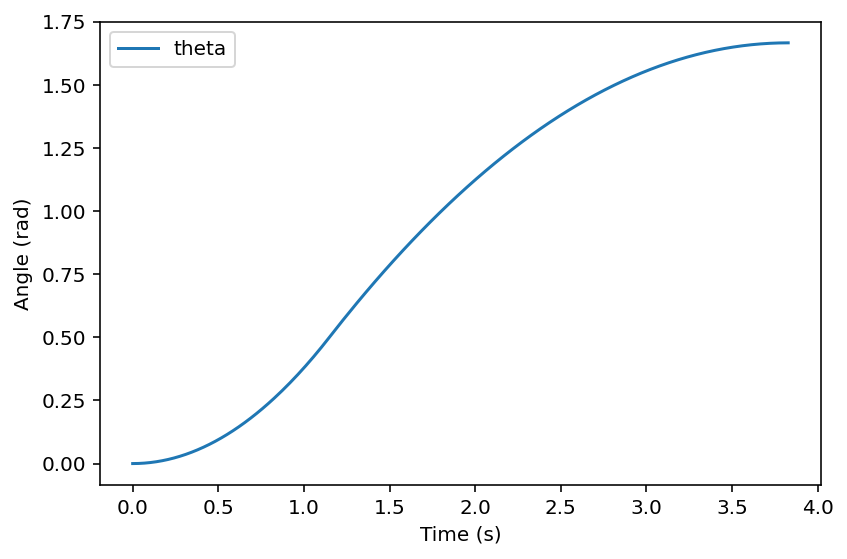

In [25]:
results.theta.plot(label='theta')
modsim.decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')

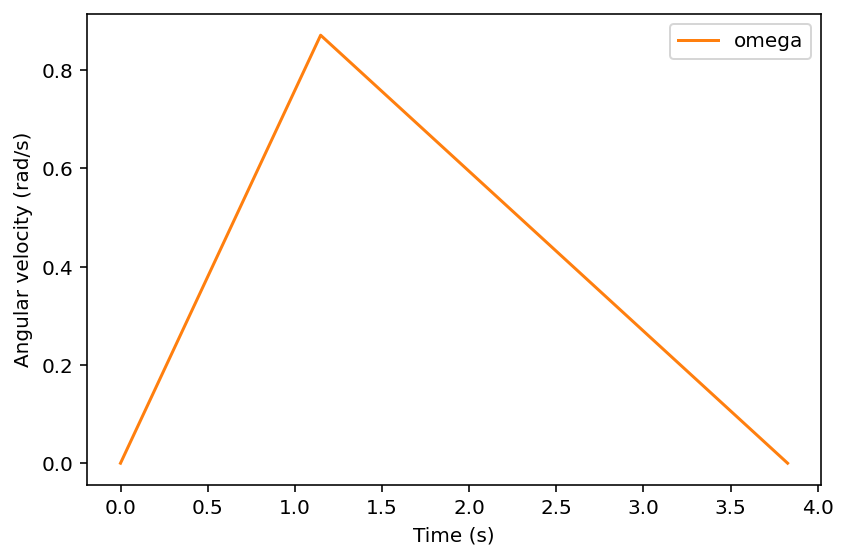

In [26]:
results.omega.plot(label='omega', color='C1')
modsim.decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')

Angular velocity, `omega`, increases linearly while I am pushing, and decreases linearly after I let go. The angle, `theta`, is the integral of angular velocity, so it forms a parabola during each phase.



### Estimating Friction

In [27]:
def run_two_phases(force, torque_friction, system):
    
    # put the specified parameters into the System object
    system1 = system.set(force=force, torque_friction=torque_friction)

    # run phase 1
    results1, details1 = modsim.run_solve_ivp(system1, slope_func, events=event_func_1)

    # get the final state from phase 1
    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]
    
    # run phase 2
    system2 = system1.set(t_0=t_2, init=init2, force=0)
    results2, details2 = modsim.run_solve_ivp(system2, slope_func, events=event_func_2)
    
    # combine and return the results
    results = results1.append(results2)
    return results

In [29]:
force = 2
torque_friction = 0.3
results = run_two_phases(force, torque_friction, system)
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-1.110223e-16


We can use `run_two_phases` to write an error function we can use, with `root_scalar`, to find the torque due to friction that yields the observed results from the first push, a total rotation of 1.5 rad.

In [30]:
def error_func_1(torque_friction, system):
    force = system.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - theta_test

In [31]:
guess1 = 0.3
error_func_1(guess1, system)

0.3 1.6666666666666667


0.16666666666666674

In [32]:
guess2 = 0.4
error_func_1(guess2, system)

0.4 1.2499999999999996


-0.25000000000000044

In [33]:
res = modsim.root_scalar(error_func_1, system, bracket=[guess1, guess2])


0.3 1.6666666666666667
0.3 1.6666666666666667
0.4 1.2499999999999996
0.33999999999999997 1.4705882352941173
0.3339999999999999 1.4970059880239515
0.33333199999999974 1.5000060000239994
0.33334866660099977 1.4999310034693274


In [34]:
actual_friction = res.root
actual_friction

0.33333199999999974

### Animating the Turntable

In [35]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis

def draw_func(t, state):
    theta, omega = state
    
    # draw a circle for the table
    circle1 = Circle([0, 0], radius_disk)
    gca().add_patch(circle1)
    
    # draw a circle for the teapot
    center = modsim.pol2cart(theta, radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')

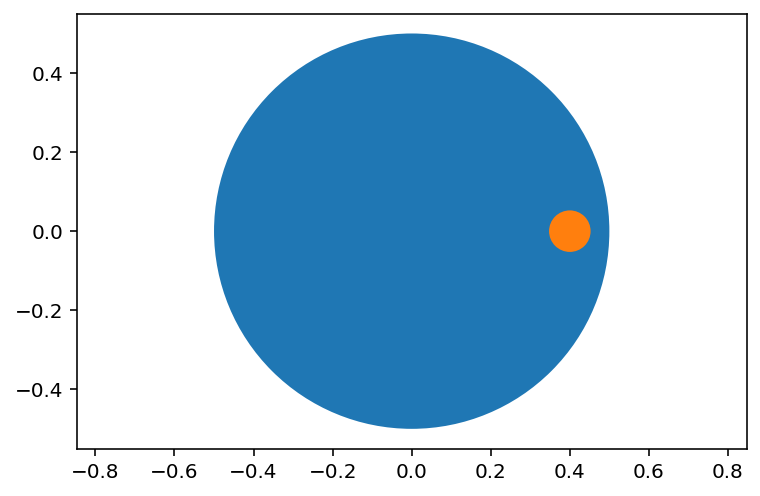

In [36]:
state = results.iloc[0]
draw_func(0, state)

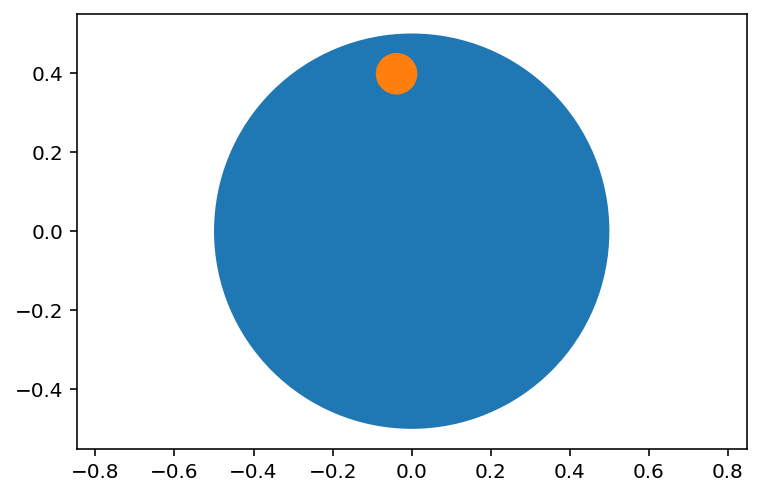

In [38]:
modsim.animate(results, draw_func)

### Exercise 1
Continuing the example from this chapter, estimate the force that delivers the teapot to the desired position. Use this `System` object, with the friction we computed in the previous section.

In [39]:
system3 = system.set(torque_friction=actual_friction)

Write an error function that takes force and system, simulates the system, and returns the difference between `theta_final` and the remaining angle after the first push.

In [54]:
remaining_angle = theta_target - theta_test

def error_func_3(force, system):
    """Error function for root_scalar.
    
    force: hypothetical value
    
    returns: offset from target value
    """
    results = run_two_phases(force, system.torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    return theta_final - remaining_angle

In [55]:
error_func_3(2, system3)

2 1.5000060000239994


-0.1415866535657937

In [57]:
error_func_3(3, system3)

3 2.250009000036003


0.60841634644621

In [58]:
res_2 = modsim.root_scalar(error_func_3, system3, bracket=[2, 3])


2 1.5000060000239994
2.0 1.5000060000239994
3.0 2.250009000036003
2.1887814496255715 1.6415926535897933
2.1886720105520903 1.6415105739563658


In [59]:
res_2

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 2.1887814496255715

In [60]:
results_2 = run_two_phases(res_2.root, system3.torque_friction, system3)

In [61]:
results_2.tail()

,theta,omega
3.515081,1.639766,3.632187e-02
3.540225,1.640565,2.724140e-02
3.565369,1.641136,1.816094e-02
3.590513,1.641478,9.080468e-03
3.615656,1.641593,2.220446e-16


In [64]:
theta_final = results_2.iloc[-1].theta
theta_final + theta_test

3.141592653589793

In [63]:
theta_target

3.141592653589793